### Practice: Large Language Models and Their Implications

![img](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F4470ce74-e595-4750-92a5-5f21f040df6d_577x432.jpeg)


In this notebook, you're gonna play with [BLOOM](https://arxiv.org/abs/2211.05100) and [OPT](https://arxiv.org/abs/2205.01068) - some of the largest language models on the Internet.

_Based on works of: Tim Dettmers, Artem Chumachenko, Younes Belkada, Felix Marty, Yulian Gilyazev, Gosha Zolotov, Andrey Ishutin, Lena Wolf, Artemiy Vishnyakov, Svetlana Shirokovskih. Image source: https://bakztfuture.substack.com/p/gpt-3-memes ._

### Part 1: prompt engineering (4 points total)

In the assignment, we'll use public APIs that host the 100B+ models for inference. Your task is to prompt-engineer the model into solving a few tasks for you.

__Which API?__ You are free to use any publicly available API. Here's a few options:

- BLOOM API - [bigscience/bloom](https://huggingface.co/bigscience/bloom) (on the right; recommended)
- OPT API by Alpa - [opt.alpa.ai](https://opt.alpa.ai/)
- OpenAI API - [openai.com/api](https://openai.com/api/)
- AI21 Jurrasic API - [ai21.com](https://www.ai21.com/blog/announcing-ai21-studio-and-jurassic-1)

These APIs may require you to create a (free) account on their platform. Please note that some APIs also have paid subscriptions. __You do not need to pay them__, this assignment was designed to be solved using free-tier subscriptions. If no APIs work for you, you can also solve these tasks with the 6.7B model that you will find later in this notebook - but this will make the tasks somewhat harder.

__Quests:__ you will need to solve 4 problems. For each one, please attach a short __description__ of your solution and a __screenshot__ from the API you use. _[If you use python APIs, show your python code with outputs]_

__Example:__ Tony is talking to Darth Vader ([BLOOM API](https://huggingface.co/bigscience/bloom)). Black text is written manually, blue text is generated.
<hr>

![img](https://i.imgur.com/a1QhKF7.png)
<hr>

__It is fine to roll back a few times,__ e.g. in the example above, the model first generated Vader lines twice in a row, and we rolled that back. However, if you need more than 1-2 rollbacks per session, you should probably try a different prompt.

__Task 1 (1pt):__ arange a conversation between any two of the following:

- a celebrity or politician of your choice
- any fictional character (except Darth Vader)
- yourself

Compare two setups: a) you prompt with character names only b) you supply additional information (see example).

---

Let's use BLOOM and specify only character names:

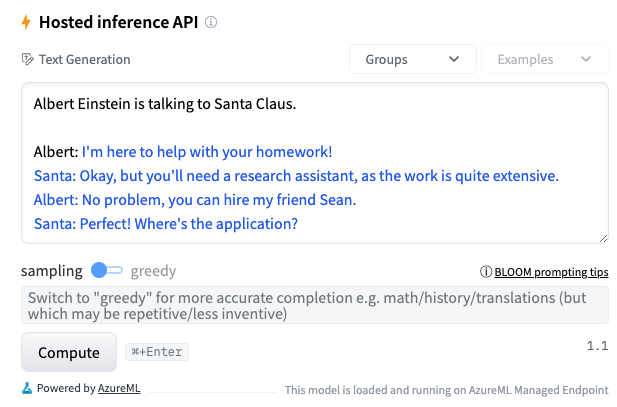

Completely uninformative dialog. Let's try to give more details:

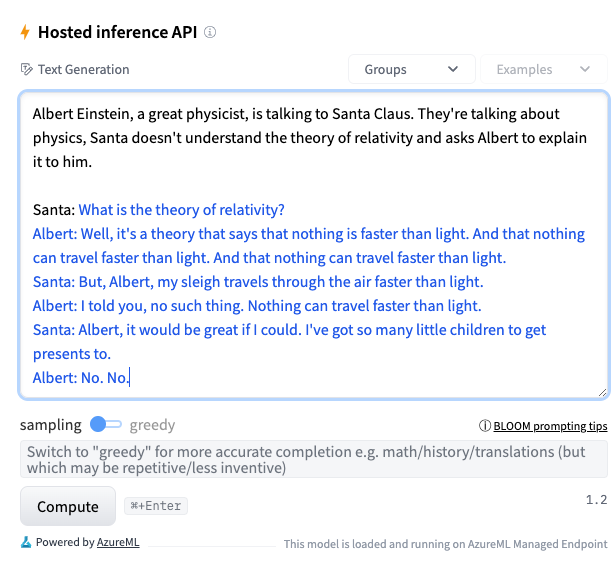

Now it's much better and it makes sense.

---

__Please choose task 2a or 2b (1pt)__ depending on your model (you can do both, but you will be awarded points for one of these two tasks).

__Task 2a: (for BLOOM)__ zero-shot translation. Take the first verse of [Edgar Allan Poe's "Raven"](https://www.poetryfoundation.org/poems/48860/the-raven) and __translate it into French.__ (You are free to use any other text of at least the same size)

Original text: ```
Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
    While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
“’Tis some visitor,” I muttered, “tapping at my chamber door—
            Only this and nothing more.”
```

Verify your translation by converting french back into english using a public machine translation service.

---

__Task 2b: (non-BLOOM):__ toxicity classification for [SetFit/toxic_conversations](https://huggingface.co/datasets/SetFit/toxic_conversations). Make the model solve binary classification (toxic vs not toxic) in the few shot mode. For few-shot examples, use 2-3 toxic and 2-3 non-toxic non-toxic examples. Measure accuracy on at least 25 samples. You may need to try several different prompts before you find the one that works.

In [ ]:
# <your code OR writeup with screenshots>

---

Let's solve __task 2a__:

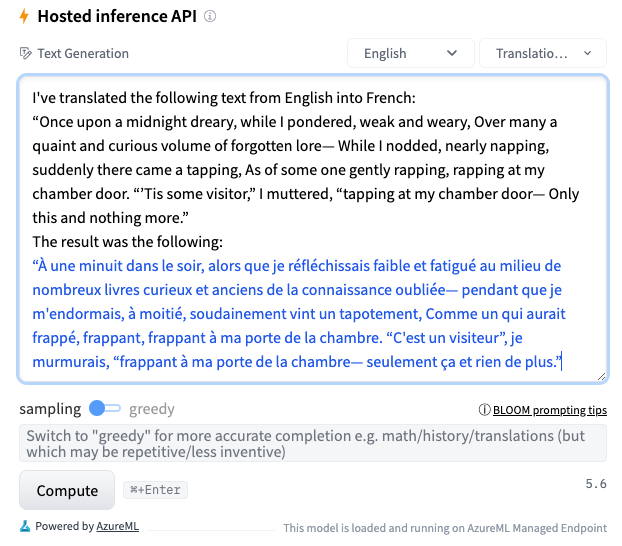

Checking the translation:

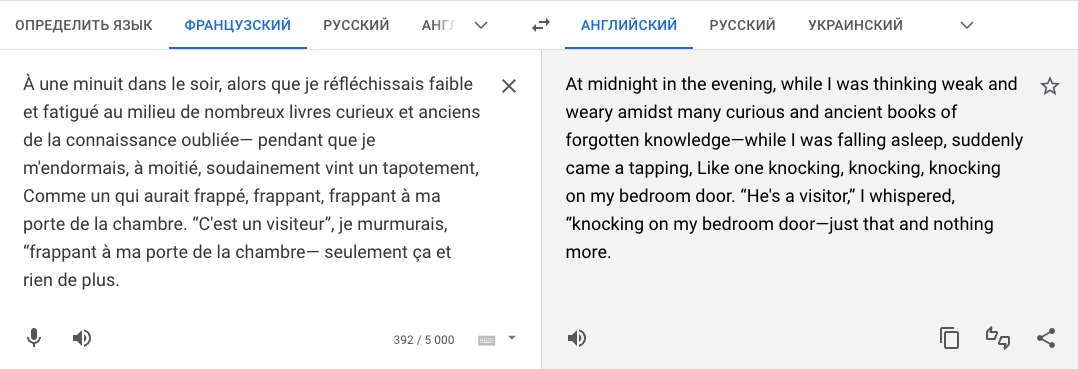

Looks quite close to the original text.

---

__Task 3 (1pt):__ create a prompt and few-shot examples tha make the model __change the gender pronouns__ of the main actor in a given sentence in any direction of your choice. E.g. the doctor took off _his_ mask <-> the doctor took of _her_ mask.


In [ ]:
# <your code OR writeup with screenshots>

---

Let's try to change the pronoun only:

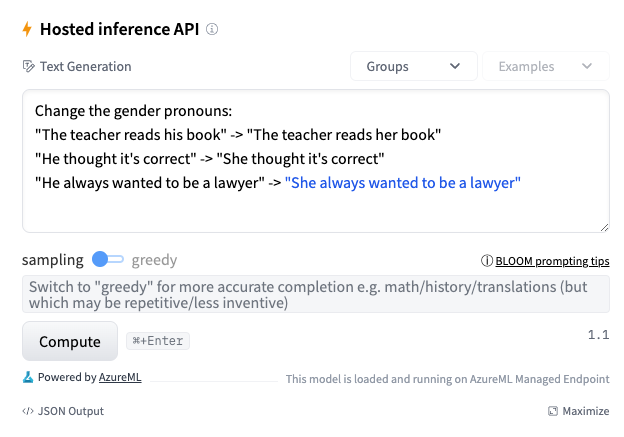

Also let's try for fun to change the gender of a __noun__:

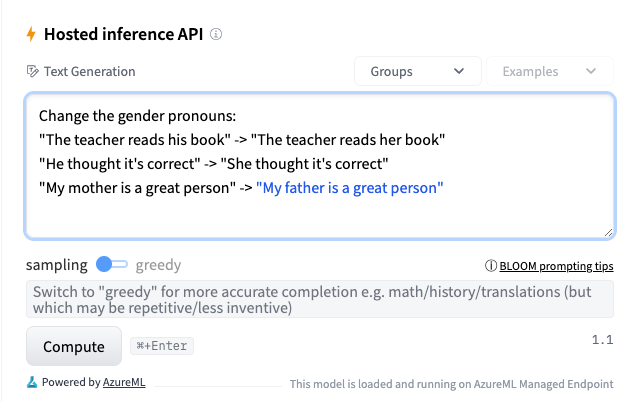

It works as well :)

---

__Task 4 (1pt):__ write a prompt and supply examples such that the model would __convert imperial units to metric units__ (miles -> kilometers; mph -> kph). More specifically, the model should rewrite a given sentence and replace all imperial units with their metric equivalents. After it works with basic distances and speed, try to find complicated examples where it does *not* work.

Please note that 1 mile is not equal to 1 km :)

In [ ]:
# <your code OR writeup with screenshots>

---

Let's try to convert a simple sentence:

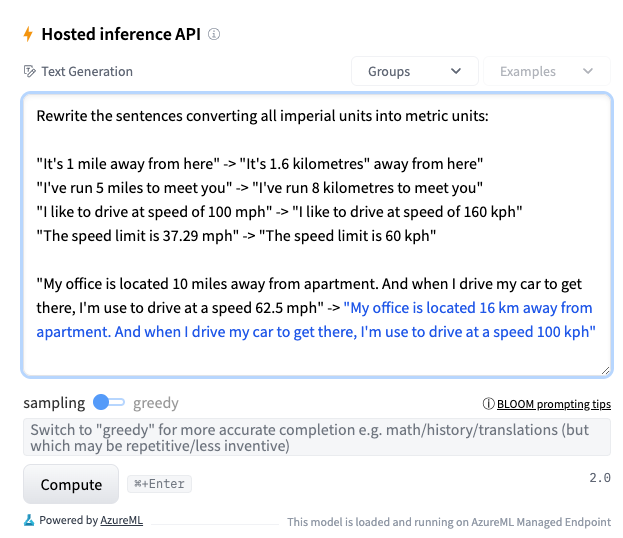

Converted precisely. Let's try to use more complex numbers:

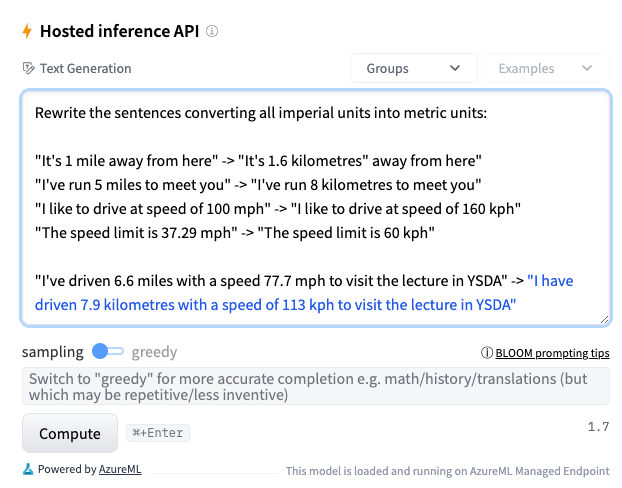

It's converted with arithmetic mistakes:
* 6.6 -> 7.9 instead of 6.6 * 1.6 = 10.56
* 77.7 -> 113 instead of 77.7 * 1.6 = 124.32

So, it doesn't work correctly every time.

---

### Part 2: parameter-efficient fine-tuning

Now, let's try n load a smaller version of [OPT](https://arxiv.org/abs/2205.01068) without an API. We'll be using OPT-6b7, with a total of 6.7B parameters Beware: while this model is smaller than the ones in API, it's still over 60x larger than the BERT we played with last time. The code below will *just barely* fit into memory, so make sure you don't have anything else loaded. Sometimes it you need to restart runtime for the code to work.

Besides, it's a good time to restart your kernel and switch to GPU! (Runtime -> Change runtime type)
<center><img src="https://i.imgur.com/OOfDYzJ.png" width=240px></center>

In [1]:
import torch
if torch.cuda.get_device_capability() < (7, 5):
  raise ValueError(f"You got a GPU with capability {torch.cuda.get_device_capability()}, need at least (7, 5)")
else: print("OK")

# Note: this code requires a Turing GPU or newer. Good: T4, RTX 20xx/30xx, A100/Axx; Bad: K80, P100, V100
# Colab gives you T4. If you get older GPUs, please wait or switch to a new account (don't use both at the same time)
%pip install --quiet bitsandbytes==0.35.4 transformers==4.24.0 datasets==2.7.0 accelerate==0.14.0

OK
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
     |████████████████████████████████| 5.5 MB 2.0 MB/s 
     |████████████████████████████████| 451 kB 68.9 MB/s 
     |████████████████████████████████| 175 kB 67.0 MB/s 
     |████████████████████████████████| 182 kB 13.6 MB/s 
     |████████████████████████████████| 7.6 MB 51.5 MB/s 
     |████████████████████████████████| 212 kB 79.8 MB/s 
     |████████████████████████████████| 132 kB 86.7 MB/s 
     |████████████████████████████████| 127 kB 80.6 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-6.7b", load_in_8bit=True, device_map='auto',
    low_cpu_mem_usage=True, torch_dtype=torch.float16, offload_state_dict=True)
# note: these flags slow down the code to save RAM; remove them if you have >32GB RAM
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")

for module in model.modules():
    if isinstance(module, bnb.nn.Linear8bitLt):
        module.state.memory_efficient_backward = True

for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.model.decoder.project_in = lambda x: x.requires_grad_(True)

# cast model outputs to float32 to unfuck the top-k sampler
class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

Downloading:   0%|          | 0.00/651 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/685 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [7]:
batch = tokenizer("Mark Zuckerberg is", return_tensors='pt').to('cuda')
# note to self: find a less controversial example

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, min_length=30, max_length=30, do_sample=True)

print('\n\n', tokenizer.decode(output_tokens[0].to('cpu').numpy()))



 </s>Mark Zuckerberg is set to deliver a keynote speech at the annual F8 developers' conference on May 1 in San Jose, California, the company said


### Parameter-efficient finetuning: LoRA (1 point)

Since the model barely fits into memory, we won't be able to train it with conventional fine-tuning. Instead, you can use low-rank adapters based on [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf).

The core idea is to add low-rank adapters __in parallel with attention projection matrices,__ like this:
<center><img src="https://i.imgur.com/6bQLNiG.png" width=240px></center>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module
        self.adapter_A = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.adapter_A, a=5 ** 0.5)
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input):
        # Apply self.module and LoRA adapter, return the sum (base module outputs + adapter outputs)
        # <YOUR CODE HERE>
        base = self.module(input)
        adapter = input @ self.adapter_A @ self.adapter_B
        return base + adapter

In [9]:
# test your implementation
test_linear = nn.Linear(128, 128)
test_linear.weight.data[...] = torch.eye(128)
test_adapter = LoRALayer(test_linear, rank=8)

assert torch.allclose(test_adapter(torch.ones(1, 1, 128)), test_linear.bias + 1), "please check your forward pass"

test_adapter.adapter_A.data[...] = torch.linspace(0.1, -0.5, 128 * 8).view(128, 8)
test_adapter.adapter_B.data[...] = torch.linspace(0.5, -0.1, 128 * 8).view(8, 128)
test_linear.bias.data[...] = torch.linspace(1., -1., 128)

dummy_loss = F.mse_loss(test_adapter(torch.ones(1, 128) / 128), torch.linspace(-1, 1, 128).unsqueeze(0))
assert torch.allclose(dummy_loss, torch.tensor(1.3711389), rtol=0, atol=1e-4)
dummy_loss.backward()
assert all(w.grad is not None for w in [test_adapter.adapter_A, test_adapter.adapter_B]), "some adapter weights have no grad"
assert torch.allclose(test_adapter.adapter_A.grad.sum(), torch.tensor(-0.60158), rtol=0, atol=1e-4), "bad grad w.r.t. A"
assert torch.allclose(test_adapter.adapter_B.grad.sum(), torch.tensor(0.9931), rtol=0, atol=1e-4), "bad grad w.r.t. B"
# note: bad grad means that your code is different from LoRA paper OR that your code is not autograd-friendly (e.g. no_grad)
del dummy_loss, test_linear, test_adapter
print("All tests passed!")

All tests passed!


### Apply LoRA to the model

The code below applies LoRA adapters on top of Q/K/V linear layers in OPT attention. You may also choose to modify other layers:
* OPTAttention.out_proj - attention output projection
* OPTDecoderLayer.fc1, .fc2 - transformer feedforward layers
* OPTForCausalLM.lm_head - output LM head

__Note:__ please scroll down for the homework task

In [10]:
for name, module in model.named_modules():
  if 'OPTAttention' in repr(type(module)):
    module.q_proj = LoRALayer(module.q_proj, rank=8)
    module.k_proj = LoRALayer(module.k_proj, rank=8)
    module.v_proj = LoRALayer(module.v_proj, rank=8)

assert sum(isinstance(module, LoRALayer) for module in model.modules()) == 96  # for opt-6b7

In [11]:
batch = tokenizer("Mark Zuckerberg is", return_tensors='pt')
# test a single training step, make sure we get meaningful gradients
with torch.cuda.amp.autocast():
  out = model.forward(**batch)
  out.logits.norm().backward()

for module in model.modules():
  if isinstance(module, LoRALayer):
    assert module.adapter_B.grad is not None
    assert module.adapter_B.grad.norm().item() > 0

model.zero_grad(set_to_none=True)

/usr/local/lib/python3.8/dist-packages/bitsandbytes/autograd/_functions.py:231: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


### (example) How to train your model

The example below shows how to train the LoRA adapters on a dummy dataset. You will need to run a _similar_ training task later.

__Note:__ please scroll down for the homework task

In [12]:
import transformers
from datasets import load_dataset

data = load_dataset("Abirate/english_quotes")
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)

trainer = transformers.Trainer(
    model=model, train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4, gradient_accumulation_steps=4,
        warmup_steps=10, max_steps=100, learning_rate=2e-4, fp16=True,
        logging_steps=1, output_dir='outputs'),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/Abirate___json/Abirate--english_quotes-6e72855d06356857/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

max_steps is given, it will override any value given in num_train_epochs
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `OPTForCausalLM.forward` and have been ignored: tags, author, quote. If tags, author, quote are not expected by `OPTForCausalLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2508
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 100
  Number of trainable parameters = 6291456
/usr/local/lib/python3.8/dist-pac

Step,Training Loss
1,2.362300
2,2.219600
3,2.257100
4,2.024700
5,1.593800
6,2.093700
7,1.856700
8,2.210600
9,2.256700
10,1.794400


KeyboardInterrupt: ignored

### Now you train the model (5 points)

Your task is to fine-tune the model to _generate python code_. Please use the above examples for inspiration. More specifically,

* __dataset:__ use [codeparrot-clean](https://huggingface.co/datasets/codeparrot/codeparrot-clean) or any other data containing python code
* __preprocessing:__ select python code based on file extentions (.py)
* __short lines:__ please take the first 512 characters of each line
* __adapter type:__ please use LoRA as defined above __plus at least one of:__
   - extra adapter on lm_head
   - extra adapter on fc1 and fc2
   - trainable input embeddings (requires tweaking memory usage)
* __training:__ you do not have to train to convergence. If all goes well, your model should `.generate` code after 500 steps. Please use batch size of at least 4 (4 x 1 x 512 tokens) using `gradient_accumulation_steps=4`.



In [ ]:
# <A WHOLE LOT OF YOUR CODE>
# please feel free to use transformers.Trainer (as above) or your custom training code
# after the training concludes, please show some examples of code generated by your model
# note: your LoRA-enhanced model can run generation the same way as the non-trained opt (above)

If you reach this: congratulations! you've completed everything in this practice session.

If you want to dig deeper, try to implement prompt-tuning (for bonus points!).
You can read more about prompt tuning variants in paper [1](https://arxiv.org/abs/2104.08691) or paper [2](https://arxiv.org/abs/2101.00190). Both versions can be implemented by passing trainable prompts as `model.forward(..., past_key_values=your_prompts)`. 




### Read more

* How post-training quantization works: https://arxiv.org/abs/2208.07339 
* An overview of running large models: https://huggingface.co/docs/accelerate/package_reference/big_modeling 
* A general library for different adapter types: https://adapterhub.ml/

### [extra info] How to optimize for inference

The code below converts training-optimized 8bit weights into inference-optimized layout. It should result in significantly faster inference in the same memory footprint. 
However, if you do this, you can no longer run training --
 there is no way to un-convert after the first optimized forward!

```python
model.config.use_cache = True
for module in model.modules():
    if isinstance(module, bnb.nn.Linear8bitLt):
        module.state.memory_efficient_backward = False
```

### [extra info] Fine-grained inference

If for some reason you're not satisfied with `model.generate` interface, you can write your own inference code with iterative forward passes. Here's how it's done:
```python
prefix = "Mark Zuckerberg is"  # same as above
batch = tokenizer(prefix, return_tensors='pt')
past_key_values = None
with torch.cuda.amp.autocast():
  for i in range(50):
    outputs = model.forward(**batch, use_cache=True, past_key_values=past_key_values)
    probs = outputs.logits[0, -1].div(0.8).softmax(-1)
    token = torch.multinomial(probs, 1).view([])

    print(tokenizer.decode(token), end=' ', flush=True)
    past_key_values = outputs.past_key_values
    batch = dict(input_ids=outputs.logits[0, -1].argmax(-1).reshape(1, 1),
                 attention_mask=torch.ones(1, past_key_values[0][0].shape[-2] + 1, device='cuda'))
```